<a href="https://colab.research.google.com/github/Naveenchander1997/Fake-and-Real-News-Detection-Using-LSTM/blob/main/Fake_And_Real_News_Detection_Using_LSTM_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Library Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Conv1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score

#Exploring Fake News

In [ ]:
fake = pd.read_csv("/content/drive/MyDrive/Fake.csv")

In [ ]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
fake.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [ ]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

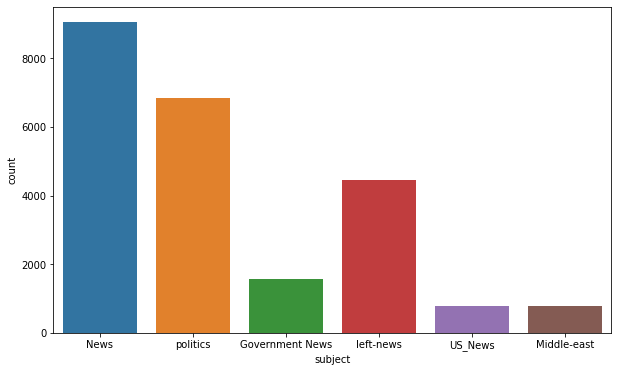

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='subject',data=fake)

##Wordcloud

In [ ]:
text = ' '.join(fake['text'].tolist())

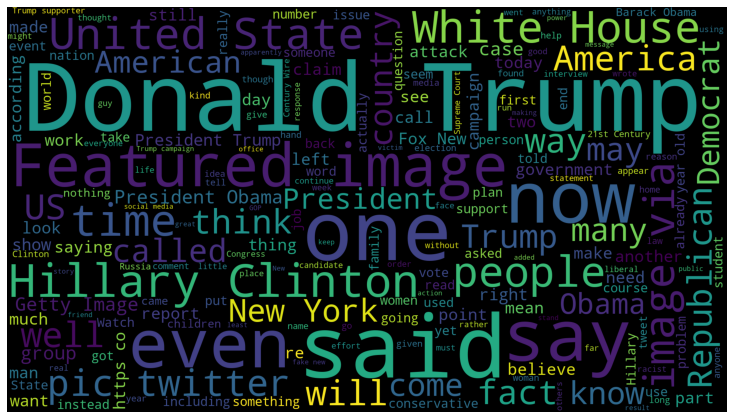

In [ ]:
wordcloud = WordCloud(width=1920,height=1080).generate(text)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#Exploring Real News

In [ ]:
real = pd.read_csv("/content/drive/MyDrive/True.csv")

In [ ]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
real.columns

Index(['title', 'text', 'subject', 'date'], dtype='object')

In [ ]:
real['subject'].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

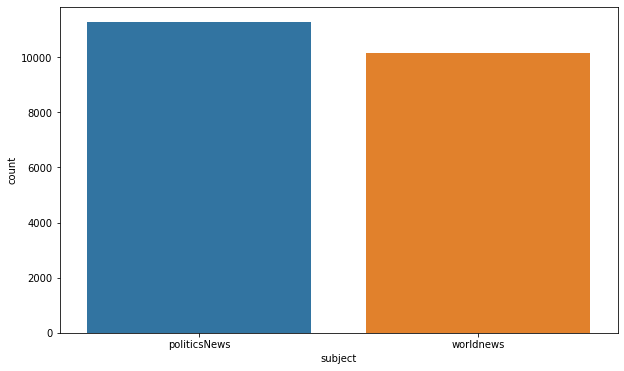

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='subject',data=real)

In [ ]:
text = ' '.join(real['text'].tolist())

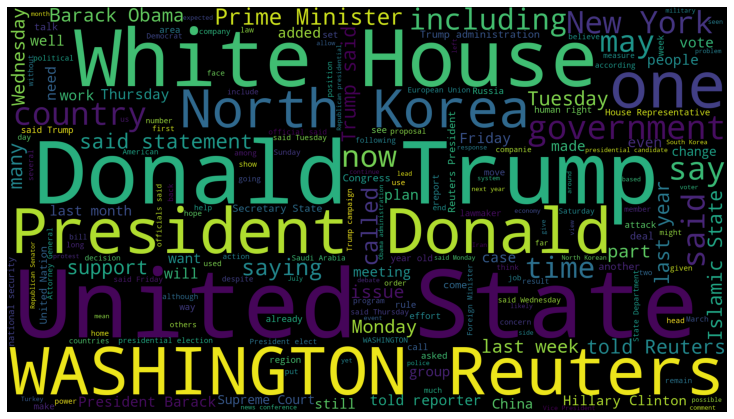

In [ ]:
wordcloud = WordCloud(width=1920,height=1080).generate(text)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#Difference in text:
Real News seems to have source of publication which is not present in fake news 
##Looking at the Data:
1. Most of text contains reuters information such as **Washington (reuters)**
2. Some text are tweets from Twitter
3. Few text do not contain publication info






#Cleaning Data

Removing Reuters or Twitter Tweets information from text

In [ ]:
real.sample(5)

,title,text,subject,date
10653,Puerto Rico needs restructuring to avoid casca...,NEW YORK/SAN JUAN (Reuters) - U.S. Treasury co...,politicsNews,"February 25, 2016"
20676,Venezuelan bishops tell pope of 'truly despera...,BOGOTA (Reuters) - Venezuela s Roman Catholic ...,worldnews,"September 8, 2017"
6099,McCain proposes $7.5 billion of new U.S. mili...,WASHINGTON (Reuters) - The head of the U.S. Se...,politicsNews,"January 24, 2017"
11301,"Eastern Libyan force says ""terrorist group"" pr...","BENGHAZI, Libya (Reuters) - A terrorist group...",worldnews,"December 27, 2017"
3198,Trump nominates Democrat Rosenworcel to serve ...,WASHINGTON (Reuters) - The U.S. Senate will ag...,politicsNews,"June 14, 2017"


In [ ]:
unknown_publishers = []
for index,row in enumerate(real.text.values):
  try:
    record = row.split('-', maxsplit = 1)
    record[1]
    assert(len(record[0])<120)
  except:
    unknown_publishers.append(index)

In [ ]:
len(unknown_publishers)

222

In [ ]:
real.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [ ]:
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [ ]:
real = real.drop(8970,axis=0)

In [ ]:
publisher = []
tmp_text = []

for index,row in enumerate(real.text.values):
  if index in unknown_publishers:
    tmp_text.append(row)
    publisher.append('unknown')

  else:
    record = row.split('-', maxsplit=1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())  

In [ ]:
real['publisher'] = publisher
real['text'] = tmp_text

In [ ]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [ ]:
real.shape

(21416, 5)

In [ ]:
empty_fake_index = [index for index,text in enumerate(fake.text.tolist()) if str(text).strip()==""]

In [ ]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [ ]:
real['text'] = real['title'] + " " + real['text']
fake['text'] = fake['title'] + " " + fake['text']

In [ ]:
real['text'] = real['text'].apply(lambda x: str(x).lower())
fake['text'] = fake['text'].apply(lambda x: str(x).lower())

#Preprocessing Text

In [ ]:
real['class'] = 1
fake['class'] = 0

In [ ]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [ ]:
real = real[['text','class']]

In [ ]:
fake = fake[['text','class']]

In [ ]:
data = real.append(fake,ignore_index=True)

In [ ]:
data.sample(5)

,text,class
24856,"thanks to capitalism, it just got a lot harde...",0
28019,fox host throws hissy fit because he can’t ca...,0
38135,general boykin on gender neutral bathrooms: “…...,0
22050,senator who has accomplished nothing is very ...,0
43001,illegal alien arrested for shooting teen girlf...,0


In [ ]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


#Special Character Removal

In [ ]:
data['text'] = data['text'].apply(lambda x: re.sub('[^A-Z a-z 0-9-]+', '', x))

In [ ]:
data.head()

,text,class
0,as us budget fight looms republicans flip thei...,1
1,us military to accept transgender recruits on ...,1
2,senior us republican senator let mr mueller do...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge much more...,1


**Word2vec** is a technique for natural language processing. The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text. Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence. As the name implies, word2vec represents each distinct word with a particular list of numbers called a vector. The vectors are chosen carefully such that a simple mathematical function (the cosine similarity between the vectors) indicates the level of semantic similarity between the words represented by those vectors.
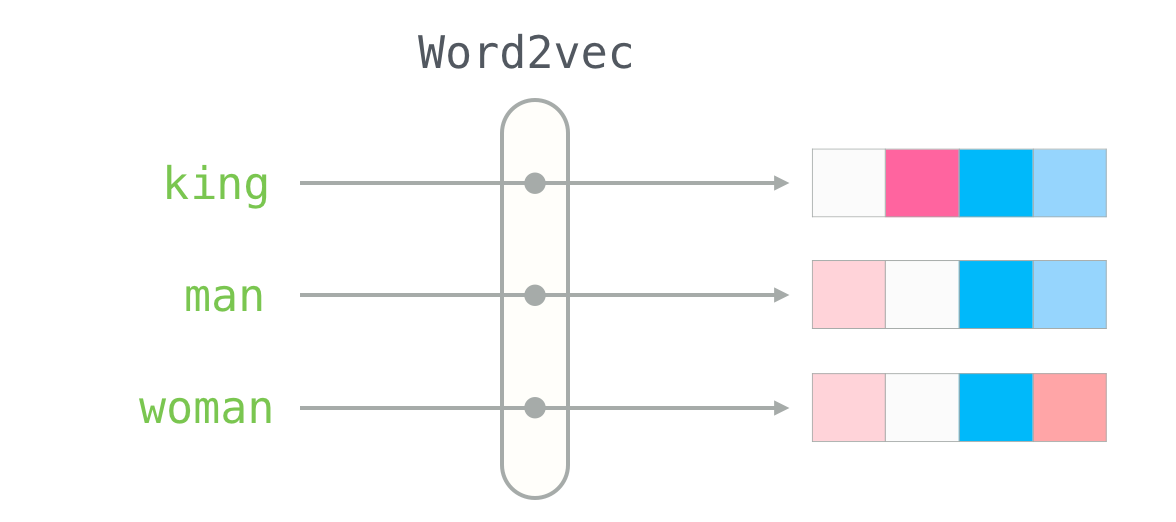

In [ ]:
import gensim

In [ ]:
y = data['class'].values

In [ ]:
x = [d.split() for d in data['text'].tolist()]

In [ ]:
type(x[0])

list

In [ ]:
print(x[0])

['as', 'us', 'budget', 'fight', 'looms', 'republicans', 'flip', 'their', 'fiscal', 'script', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'us', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'a', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', '2018', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'us', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to', 'be', 'linked', 'to', 'other', 'issues',

In [ ]:
DIM = 100
w2vec_model = gensim.models.Word2Vec(sentences=x,size=DIM,window=10,min_count=1)

In [ ]:
len(w2vec_model.wv.vocab)

235207

In [ ]:
w2vec_model.wv['politics']

array([ 0.07027911,  0.88284266,  1.2853036 , -3.3954427 ,  0.60187536,
       -1.4788194 ,  2.9400437 , -0.33133975,  2.6173906 , -3.0007854 ,
        1.8979784 ,  1.5655313 , -1.1527623 , -2.4220443 , -0.99825484,
       -0.4759356 , -0.5269714 ,  0.23326868, -0.44530797, -0.6358076 ,
        0.84520674,  1.3495362 ,  0.5027761 ,  4.1708364 , -1.5141089 ,
       -1.5306628 , -0.724037  , -0.74873644,  2.8471723 , -2.7576427 ,
       -1.2903234 , -0.99758106,  5.037748  , -0.43905005, -1.191448  ,
        3.8794363 , -3.765336  , -0.22267216, -4.9875784 , -3.3968072 ,
       -0.96332616,  1.3064327 , -2.7498882 , -3.3987625 ,  2.4613707 ,
       -0.59623563, -0.85930336, -1.7019435 , -1.3946655 ,  1.4948504 ,
        1.0877649 ,  4.688748  ,  1.0935462 ,  1.3046944 ,  0.45947796,
        1.443166  , -1.9684622 , -0.22769757,  1.1546756 , -1.6115217 ,
       -0.8678715 ,  1.7941883 ,  1.7140921 ,  1.5618331 ,  0.00734183,
       -1.1527342 ,  2.9292037 ,  1.4094042 , -2.0215878 ,  0.19

In [ ]:
w2vec_model.wv.most_similar('attack')

[('attacks', 0.800021231174469),
 ('massacre', 0.6280254125595093),
 ('bombing', 0.6244970560073853),
 ('attacklydie', 0.6131119132041931),
 ('raid', 0.6002064943313599),
 ('incident', 0.5916431546211243),
 ('bombings', 0.590314507484436),
 ('strike', 0.5894200801849365),
 ('blast', 0.571215033531189),
 ('shooting', 0.5595204830169678)]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)

In [ ]:
X = tokenizer.texts_to_sequences(x)

In [ ]:
# tokenizer.word_index

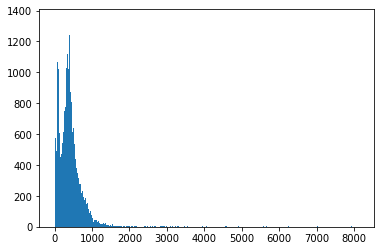

In [ ]:
plt.hist([len(x) for x in X],bins=700)
plt.show()

In [ ]:
nos = np.array([len(x) for x in X])
len(nos[nos>1000])

1588

In [ ]:
maxlen = 1000
X = pad_sequences(X,maxlen=maxlen)

In [ ]:
len(X[155])

1000

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [ ]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size, DIM))
  for word, i in vocab.items():
     weight_matrix[i] = model.wv[word]

  return weight_matrix

In [ ]:
Embedding_vectors = get_weight_matrix(w2vec_model)

In [ ]:
Embedding_vectors.shape

(235208, 100)

#Creating Model

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=DIM, weights=[Embedding_vectors], input_length=maxlen, trainable=True))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         23520800  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 23,638,177
Trainable params: 23,638,177
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X,y,shuffle=True)

In [ ]:
model.fit(x_train,y_train,validation_split=0.3,epochs=6)

Epoch 1/6
737/737 [==============================] - 216s 287ms/step - loss: 0.2067 - accuracy: 0.9185 - val_loss: 0.0541 - val_accuracy: 0.9817
Epoch 2/6
737/737 [==============================] - 207s 280ms/step - loss: 0.0533 - accuracy: 0.9826 - val_loss: 0.0383 - val_accuracy: 0.9867
Epoch 3/6
737/737 [==============================] - 206s 280ms/step - loss: 0.0212 - accuracy: 0.9932 - val_loss: 0.0250 - val_accuracy: 0.9916
Epoch 4/6
737/737 [==============================] - 210s 284ms/step - loss: 0.0121 - accuracy: 0.9959 - val_loss: 0.0177 - val_accuracy: 0.9945
Epoch 5/6
737/737 [==============================] - 205s 279ms/step - loss: 0.0047 - accuracy: 0.9989 - val_loss: 0.0181 - val_accuracy: 0.9944
Epoch 6/6
737/737 [==============================] - 204s 277ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 0.0182 - val_accuracy: 0.9950


In [ ]:
y_pred = (model.predict(x_test) >=0.5).astype(int)

In [ ]:
accuracy_score(y_test,y_pred)

0.9959910913140312

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5922
           1       1.00      1.00      1.00      5303

    accuracy                           1.00     11225
   macro avg       1.00      1.00      1.00     11225
weighted avg       1.00      1.00      1.00     11225



In [ ]:
x =["Misinformation related to coronavirus COVID-19 pandemic is in the form of social media messages related to home remedies that have not been verified, fake advisories and conspiracy theories.[23][24] At least two people have been arrested for spreading fake news about the coronavirus pandemic.[25][26] On 7 March 2020, Prime Minister Narendra Modi made an appeal to not believe any rumours related to the pandemic.[23] The Press Information Bureau brought out a fact check on 24 March that stories about a financial emergency being imposed in India are fake.[27][28] To counteract this, over 400 Indian Scientists are working together to debunk false information about the virus, as of 14 April.[29]"]
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x,maxlen=maxlen)

In [ ]:
(model.predict(x) >=0.5).astype(int)

array([[0]])

In [ ]:
x =["Delhi Oxygen Concentrator Banks: Patients who have been discharged from hospitals but still need medical oxygen can reach out too, Arvind Kejriwal said."]
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x,maxlen=maxlen)

In [ ]:
(model.predict(x) >=0.5).astype(int)

array([[1]])